<a href="https://colab.research.google.com/github/oscarserc/VISION_por_COMPUTADORA/blob/main/CV_Practica_4a_Segmentacion_continuar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device



'cpu'

In [ ]:

# CARGAMOS EL CONJUNTO DE ENTRENAMIENTO (El dataset VOC)
# =====================================

train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


5717

In [ ]:
# REPASAMOS LA ESTRUCTURA DEL TARGET:
# ==================================

# ES UN DICCIONARIO DE PYTHON ---->
#
#   { 'annotation': { 'filename'    : ...,
#                     'folder'      : ...,
#                     'object'      :  [                                                                          # LISTA: contiene coordenadas y nombre de objetos en la imagen
#                                       {'bndbox': 'x_max': x_1, 'x_min': x_2, 'y_max': y_1, 'y_min':y_2},        # <------ OBJETO 1 nombre y coordenadas
#                                       'name': nombre_objeto_1, 
#                                       {'bndbox': 'x_max': x_1, 'x_min': x_2, 'y_max': y_1, 'y_min':y_2},        # <------ OBJETO 2 nombre y coordenadas
#                                       'name': nombre_objeto_2
#                                      ]
#                       ...
#                    }
#   }

In [ ]:
classes = ['backward','aeroplane','bicycle','bird','boat','bottle',
           'bus','car','cat','chair','cow','diningtable','dog',
           'horse','motorbike','person','pottedplant','sheep','sofa',
           'train','tvmonitor']

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anotaciones = label['annotation']['object']
  if type(anotaciones) is not list:
    anotaciones = [anotaciones]
  labels = np.array([classes.index(ann['name']) for ann in anotaciones])
  coordenadas_cajas = [ann['bndbox'] for ann in anotaciones]
  coordenadas_cajas = np.array([[int(bb['xmin']), int(bb['ymin']), int(bb['xmax']), int(bb['ymax'])] for bb in coordenadas_cajas])
  anotaciones = (labels, coordenadas_cajas)
  return img_np, anotaciones  

def plot_anns(img, anotaciones, ax=None, bg=-1):
  if not ax:
    fig, ax = plt.subplots(figsize=(10,6))
  ax.imshow(img)
  labels, coordenadas = anotaciones
  for lab, bb in zip(labels, coordenadas):
    if bg == -1 or lab != bg:
      x, y, xm, ym = bb
      w, h = xm - x, ym - y
      rectangulo = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      texto      = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      texto.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rectangulo)



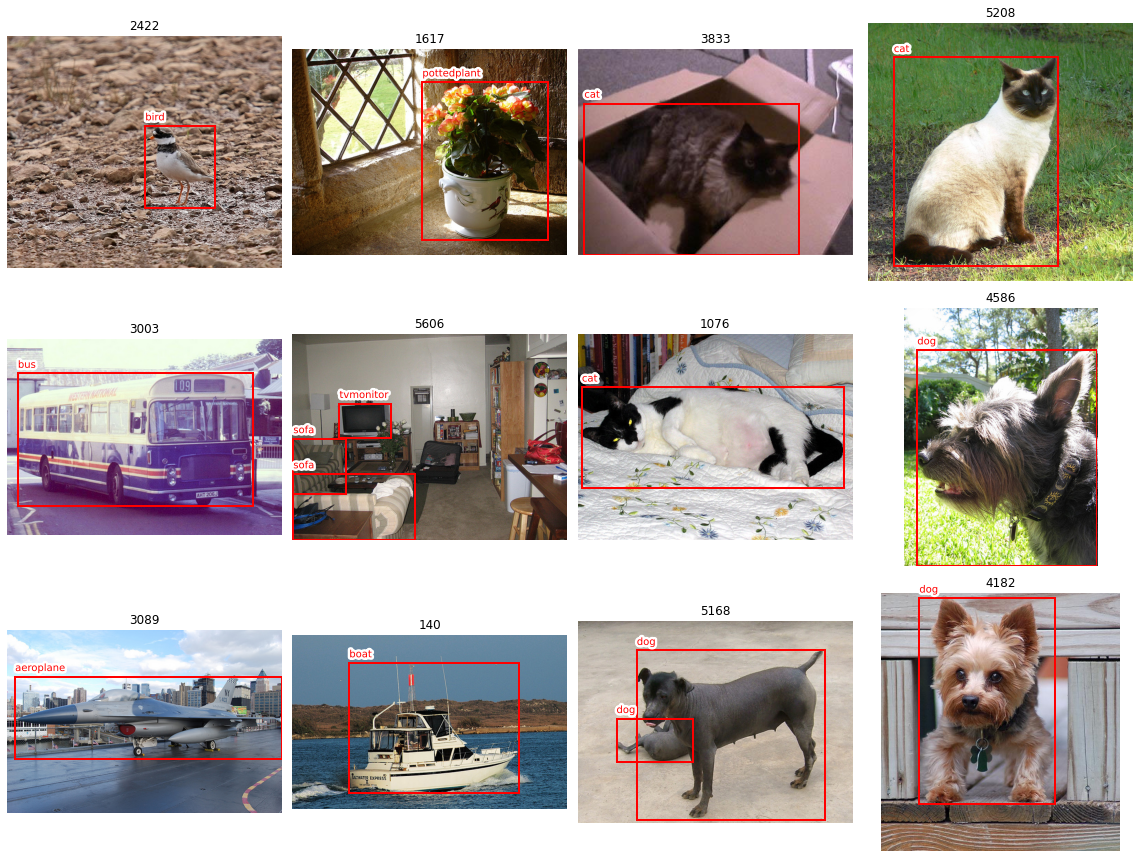

In [ ]:

r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
  for _c in range(c):
   ax = plt.subplot(r, c, _r*c + _c + 1)
   ix = random.randint(0, len(train) - 1)
   ax.set_title(ix)
   img_np, anotaciones = get_sample(ix)
   plot_anns(img_np, anotaciones, ax)
   plt.axis('off')
plt.tight_layout()
plt.show()    


In [ ]:

# EL ALGORITMO SSD
# ================
#
# Ahora trabajamos con un conjunto de cajas predefinidas que rastreando
# las imágenes nos van a permitir localizar los objetos

def norm(bb, shape):
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

def xyxy2xywh(bb):
  return torch.stack([bb[:,0], bb[:,1], bb[:,2] - bb[:,0], bb[:,3] - bb[:,1]], axis=1)

def generate_anchors(scales, centers, sizes):
  k, anchors, grid_size = [], [], []
  for s in scales:
    cnt = 0
    for (x,y) in centers:
      for (w,h) in sizes:
        for i in range(s):
          for j in range(s):
            anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s)
            grid_size.append(np.array([1./s, 1./s]))
        cnt = cnt + 1
    k.append(cnt)
  return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()                



In [ ]:

def plot_anchors(img, anotaciones, anchors, ax=None, overlap=False):
  # Recordemos que ANOTACIONES es una tupla con: la ETIQUETA y las COORDENADAS de la caja
  # · label ----> viene en un array
  # · bbs  -----> viene en un array, del tipo: [x_min, y_min, x_max, y_max], y representa las coordenadas

  if not ax:
    fig, ax = plt.subplots(figsize=(10,6))
  ax.imshow(img)
  labels, bbs = anotaciones

  anchors  = xyxy2xywh(anchors)
  _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
  for a in _anchors:
    x, y, w, h = a
    rect       = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)

  labels, bbs = anotaciones
  for lab, bb in zip(labels, bbs):
    x, y, xm, ym = bb
    w = xm - x
    h = ym - y
    rect = mpatches.Rectangle((x,y), w, h, fill=False, edgecolor='red', linewidth=2)
    text = ax.text(x, y -  10, classes[lab], {'color':'red'})
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    ax.add_patch(rect)          



(138, [3, 3, 3])

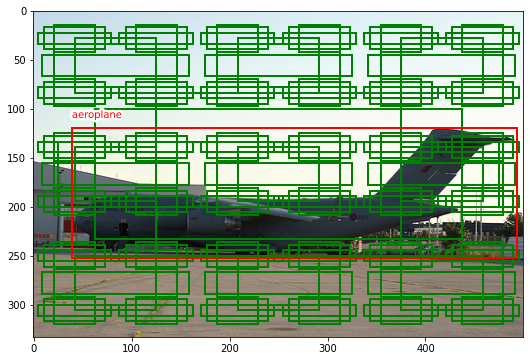

In [ ]:
ix = 4445
img_np, anotaciones = get_sample(ix)
labels, bbs = anotaciones

scales  = [6, 3, 1]
centers = [(0.5, 0.5)]
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

plot_anchors(img_np, anotaciones, anchors)
len(anchors), k


# **AHORA PASAMOS A CONSTRUIR EL MODELO** (Inspirado en el modelo SSD)


In [ ]:

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
  return torch.nn.Sequential(
      torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(pk, stride=ps)
  )

def flatten_conv(x, k):
  return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)


# CLASE OUT_CONV
# ==============

class out_conv(torch.nn.Module):
  def __init__(self, c_in, k, n_classes):
    super().__init__()
    self.k = k
    self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
    self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)

  def forward(self, x):
    return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
    ]      

def conf(c_in, c_o, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding),
      nn.ReLU()
  )


# CLASE SSD
# =========
class SSD(torch.nn.Module):
  def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
    super().__init__()
    # BACKBONE
    # --------
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.conv5 = block(64, 64)
    self.conv6 = block(64, 64)
    # HEAD
    # ----
    self.k = k
    self.out4 = out_conv(64, self.k[0], n_classes)
    self.out5 = out_conv(64, self.k[1], n_classes)
    self.out6 = out_conv(64, self.k[2], n_classes)

  def forward(self, x):
    # BACKBONE
    # --------
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x4 = self.conv4(x)
    x5 = self.conv5(x4)
    x6 = self.conv6(x5)
    # HEAD
    # ----
    o1l, o1c = self.out4(x4)
    o2l, o2c = self.out5(x5)
    o3l, o3c = self.out6(x6)
    return torch.cat([o1l, o2l, o3l], dim=1), torch.cat([o1c, o2c, o3c], dim=1)


In [ ]:
red = SSD(n_classes=len(classes), k=k)
salidas = red(torch.rand((64,3,100,100)))
salidas[0].shape, salidas[1].shape

(torch.Size([64, 138, 4]), torch.Size([64, 138, 21]))

# **CONSTRUIMOS LA FUNCIÓN DE PÉRDIDA**

In [ ]:
def actn_to_bb(actn, anchors, grid_size):
  actn_bbs = torch.tanh(actn)
  actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5
  actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5
  return torch.cat([actn_p1, actn_p2], dim=1)

In [ ]:
def map_to_ground_truth(overlaps):
  prior_overlap, prior_idx = overlaps.max(1)
  gt_overlap, gt_idx       = overlaps.max(0)
  gt_overlap[pior_idx]     = 1.99
  for i, o in enumerate(prior_idx):
    gt_idx[o] = i
  return gt_overlap, gt_idx  

In [ ]:

# AHORA COMBINAMOS Localicación + Clasificación
# para generar la FUNCIÓN DE PÉRDIDA
# ---------------------------------------------

class SSDLoss(torch.nn.Module):
  def __init__(self, anchors, grid_size, threshold=0.4):
    super().__init__()
    self.loc_loss   = torch.nn.L1Loss()
    self.class_loss = torch.nn.CrossEntropyLoss()
    self.anchors    = anchors.to(device)
    self.grid_size  = grid_size.to(device)
    self.threshod   = threshold

  def forwar(self, preds, target):
    pred_bbs, pred_cs = preds
    tar_bbs, c_t      = target
    loc_loss, clas_loss = 0, 0
    for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
      labels = torch.zeros(len(self.anchors)).long().to(device)
      if tar_bb.shape[0] is not 0:
        overlaps = torchvision.ops.box_iou(tar_bb, self.anchors)
        gt_overlap, gt_idx = map_to_ground_truth(overlaps)
        pos = gt_overlap > self.threshold
        pos_idx = torch.nonzero(pos)[:,0]
        tar_idx = gt_idx[pos_idx]
        pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size)
        _anchors = pred_bb[pos_idx]
        tar_bb   = tar_bb[tar_idx]
        # GENERAMOS LA FUNCIÓN DE PÉRDIDA QUE NOS INTERESA
        # ------------------------------------------------
        loc_loss += self.loc_loss(_anchors, tar_bb)
        labels[pos_idx] = tar_c[tar_idx]
        clas_loss += self.class_loss(pred_c, labels)  
    return clas_loss + loc_loss    



# **ENTRENAMIENTO**